In [456]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
from plotly import graph_objects as go
pd.set_option('display.max_rows', 300)

%load_ext autoreload

from charts import plot_line, plot_bar, plot_peak, print_charts_country
from features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [611]:
date_apple = '2020-05-17'

In [3]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    df_region['region'] = region
    
    return df_region

In [4]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [6]:
def melt_apple_df(dfapple):
    _list = list()
    for region in dfapple.region.unique():
        dfapple_region = apple_filter_region(dfapple, region)
        df = add_variables_apple(dfapple_region)
        _list.append(df)
    ret = pd.concat([df for df in _list])
    return ret

In [7]:
def melt_rki_df(df_rki_germany):
    _list = list()
    for land in df_rki_germany.land.unique():
        df = df_rki_germany.loc[df_rki_germany.land == land, :].copy()
        pop = int(df.loc[df.land==land, 'population'][0])
        df = add_variables_covid(df, 'confirmed', population=pop)
        df = add_variables_covid(df, 'dead', population=pop)
        _list.append(df)
    return pd.concat([df for df in _list])

# World Bank Data

In [165]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country_wb'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country_wb'] = df_population['country_wb'].astype('string')
df_population['iso_code'] = df_population.index
df_population.head(1)

,region,country_wb,population,iso_code
id,,,,
ABW,Latin America & Caribbean,Aruba,105845.0,ABW


In [166]:
df_population.loc[df_population.iso_code == 'XKX', 'iso_code'] = 'XKS'

# RKI and Apple Data

In [648]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")
dfapple = pd.read_csv(f"data-input/apple-mobility/applemobilitytrends-{date_apple}.csv")

df_rki_germany = pd.read_csv("data-processed/RKI-reports.csv")

df_population_de = pd.read_csv('data-input/german_lander_population.csv')

# JHU Data

In [614]:
dfcovid_conf = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_uid = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

df_uid = df_uid.loc[df_uid['Province_State'].isnull() == True, ['iso3', 'Country_Region']]
df_uid.columns = ['iso_code', 'country']

dfcovid_conf.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_conf.columns[4:])
dfcovid_dead.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_dead.columns[4:])
dfcovid_conf = dfcovid_conf.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))
dfcovid_dead = dfcovid_dead.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))

In [217]:
dfcovid_conf.head(1)

,state,country,lat,lng,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,iso_code
0,NaN,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,AFG


In [218]:
# dfcovid_conf.loc[dfcovid_conf.country.str.contains('China') == True]#.head(1) ##.sort_values(by='region')

In [219]:
# dfcovid_conf.loc[dfcovid_conf.country.str.contains('Australia') == True, [c for c in dfcovid_conf.columns if '/20' in c]].sum()

In [220]:
def fix_countries(df):
    df.loc[df.state.str.contains('Hong Kong') == True, 'iso_code'] = 'HKG'
    df.loc[df.state.str.contains('Macau') == True, 'iso_code'] = 'MAC'
    df.loc[df.state.str.contains('Hong Kong') == True, 'state'] = np.NaN
    df.loc[df.state.str.contains('Macau') == True, 'state'] = np.NaN
    df.loc[df.iso_code.str.contains('HKG') == True, 'country'] = 'Hong Kong'
    df.loc[df.iso_code.str.contains('MAC') == True, 'country'] = 'Macau'

    s = df.loc[df.iso_code == 'CHN', [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'China'
    s['iso_code'] = 'CHN'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)
    
    s = df.loc[df.country.str.contains('Canada') == True, [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'Canada'
    s['iso_code'] = 'CAN'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)

    s = df.loc[df.country.str.contains('Australia') == True, [c for c in df.columns if '/20' in c]].sum()
    s['country'] = 'Australia'
    s['iso_code'] = 'AUS'
    df = pd.concat([df, s.to_frame().T,] ,axis=0)
    
    return df
dfcovid_conf = fix_countries(dfcovid_conf)
dfcovid_dead = fix_countries(dfcovid_dead)

In [221]:
dfcovid_conf = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :]
dfcovid_dead = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :]

In [222]:
df_population_joined = df_population.merge(dfcovid_conf.loc[:, ['iso_code', 'country']].drop_duplicates(), how='outer',  on='iso_code',  suffixes=('_x', '_y'), left_index=False, right_index=False,)
df_population_joined.tail(1)

,region,country_wb,population,iso_code,country
221,NaN,<NA>,NaN,ESH,Western Sahara


In [223]:
# df_population_joined.loc[df_population_joined.country.isnull() == True].sort_values(by='region')

In [224]:
# df_population_joined.loc[df_population_joined.country_wb.isnull() == True].head(10)

In [225]:
# dfcovid_conf.loc[dfcovid_conf.country == 'China'].head(10)

## load and write Germany GeoJSON

In [206]:
geojson_path =  "../deutschlandGeoJSON/2_bundeslaender/3_mittel.geo.json"
df_geojson = gpd.read_file(geojson_path)
df_geojson.columns = ["iso_code", 'name', 'type','geometry']
df_geojson = df_geojson.loc[:, ["iso_code", 'geometry']]
df_geojson['iso_code'] = df_geojson.iso_code.str.replace('DE-', '')
geojson = json.loads(df_geojson.set_index('iso_code').to_json())
json.dump(geojson, open('data_geo_de.json', 'w'))

### Transpose Confirmed Cases

In [226]:
dfcovid_conf_t = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :].T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['country', :].astype(str)
dfcovid_conf_t.drop(['country'], axis=0, inplace=True)
df_country_coords = dfcovid_conf_t.loc[['lat', 'lng'], :]
dfcovid_conf_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [227]:
dfcovid_dead_t = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :].T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['country', :].astype(str)
dfcovid_dead_t.drop(['country'], axis=0, inplace=True)


dfcovid_dead_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


# Prepare Datasets

### RKI

In [635]:
# df_rki_germany = df_rki_germany.loc[df_rki_germany['date'] != '2020-05-18']
# df_rki_germany = df_rki_germany.drop('Unnamed: 0', axis=1)
df_rki_germany['confirmed'] = df_rki_germany['confirmed'].astype(float)
# df_rki_germany.loc[df_rki_germany.confirmed.str.contains(','), 'confirmed'] = df_rki_germany.confirmed.str.replace(',', '')
df_rki_germany['confirmed'] = df_rki_germany['confirmed'].astype(int)




In [651]:
# df_rki_germany.to_csv("data-processed/RKI-reports.csv")

df_rki_germany.drop(['date.1', 'name', 'iso_code','capital','area','population'], axis=1).to_csv("data-processed/RKI-reports.csv")

In [647]:
df_rki_germany = df_rki_germany.merge(df_population_de, 
                                            how='inner',
                                            left_on='land',
                                            right_on='name',
                                            left_index=False,
                                            right_index=False,
                                            suffixes=('_x', '_y'),)

df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
df_rki_germany.set_index('date', inplace=True, drop=False)
df_rki_germany
# df_rki_germany_processed = melt_rki_df(df_rki_germany)

,date,land,confirmed,dead,date.1,name_x,iso_code_x,capital_x,area_x,population_x,name_y,iso_code_y,capital_y,area_y,population_y,name,iso_code,capital,area,population
date,,,,,,,,,,,,,,,,,,,,
2020-03-04,2020-03-04,Baden-Wuerttemberg,50,0,2020-03-04,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533
2020-03-04,2020-03-04,Hamburg,3,0,2020-03-04,Hamburg,HH,Hamburg,755,1841179,Hamburg,HH,Hamburg,755,1841179,Hamburg,HH,Hamburg,755,1841179
2020-03-04,2020-03-04,Brandenburg,1,0,2020-03-04,Brandenburg,BB,Potsdam,29654,2511917,Brandenburg,BB,Potsdam,29654,2511917,Brandenburg,BB,Potsdam,29654,2511917
2020-03-04,2020-03-04,Bremen,3,0,2020-03-04,Bremen,HB,Bremen,420,682986,Bremen,HB,Bremen,420,682986,Bremen,HB,Bremen,420,682986
2020-03-04,2020-03-04,Rhineland-Palatinate,7,0,2020-03-04,Rhineland-Palatinate,RP,Mainz,19854,4084844,Rhineland-Palatinate,RP,Mainz,19854,4084844,Rhineland-Palatinate,RP,Mainz,19854,4084844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,2020-05-18,Hesse,9337,439,2020-05-18,Hesse,HE,Wiesbaden,21115,6265809,Hesse,HE,Wiesbaden,21115,6265809,Hesse,HE,Wiesbaden,21115,6265809
2020-05-18,2020-05-18,Hamburg,5037,232,2020-05-18,Hamburg,HH,Hamburg,755,1841179,Hamburg,HH,Hamburg,755,1841179,Hamburg,HH,Hamburg,755,1841179
2020-05-18,2020-05-18,Rhineland-Palatinate,6490,217,2020-05-18,Rhineland-Palatinate,RP,Mainz,19854,4084844,Rhineland-Palatinate,RP,Mainz,19854,4084844,Rhineland-Palatinate,RP,Mainz,19854,4084844


### Apple

In [639]:
df_apple_processed = melt_apple_df(dfapple)
apple_lands = {'Baden-Württemberg': 'Baden-Wuerttemberg',
               'The Free Hanseatic City of Bremen':'Bremen',
               'Mecklenburg-Vorpommern': 'Mecklenburg-Western Pomerania'
              }
df_apple_processed['region'] = df_apple_processed['region'].apply(lambda x: apple_lands.get(x) if apple_lands.get(x) is not None else x)

In [640]:
df_apple_processed_de = df_apple_processed.loc[df_apple_processed.region.isin(df_rki_germany_processed.land.unique()), ['region', 'driving', 'walking', 'transit']]
df_apple_processed_de['date'] = df_apple_processed_de.index
df_apple_processed_de = df_apple_processed_de.rename(columns={'region': 'land'})

### JHU

In [348]:
def prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15'):
    try:
        pop = df_population_joined.loc[df_population_joined.country == country, 'population'].values[0]
        iso_code = df_population_joined.loc[df_population_joined.country == country, 'iso_code'].values[0]
        region = df_population_joined.loc[df_population_joined.country == country, 'region'].values[0]
    except:
        print('No population data for :', iso_code)
        return False
    
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=pop)

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=pop)
    
    df['land'] = country
    df['iso_code'] = iso_code
    df['region_wb'] = region
    df['population_wb'] = pop
    
    return df

def melt_jhu_df(df_confirmed, df_dead):
    _list = list()
    for country in df_confirmed.columns:
        df = prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15')
        if type(df) == pd.core.frame.DataFrame:
            _list.append(df)
    return pd.concat([df for df in _list])

In [349]:
df_jhu_processed = melt_jhu_df(dfcovid_conf_t, dfcovid_dead_t)
df_jhu_processed = df_jhu_processed.loc[df_jhu_processed.region_wb.isnull()==False]

In [350]:
df_eu_countries = pd.read_csv('eu_countries.csv')
df_jhu_processed.loc[df_jhu_processed.land.isin(df_eu_countries.Country) == True, 'region_wb'] = 'European Union'

In [417]:
df_jhu_processed['date'] = df_jhu_processed.index

In [351]:
# print("Mobility max date:", max(df_apple_processed.index))
# print("RKI max date", max(df_rki_germany_processed.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))

Covi world max date 2020-05-16 00:00:00
Covi world max date 2020-05-16 00:00:00


# Save processed data

In [609]:
DASH_COLUMNS = ['land', 'date', 'iso_code', 'confirmed_change', 'confirmed', 'confirmed_per_100k', 'population_wb', 'region_wb',
                'confirmed_active_cases', 'confirmed_change_per_100k',
                'confirmed_change_pct_3w', 'confirmed_doubling_days_3w_avg3', 
                'dead_change', 'dead', 'dead_per_100k', 'dead_change_per_100k', 'dead_doubling_days']

In [610]:
df_jhu_processed.to_csv('data-processed/data_jhu_world.csv', index=False)
df_jhu_processed.loc[:, DASH_COLUMNS].to_csv('dash/data/data_jhu_world.csv', index=False)

In [641]:
df_rki_germany_processed.to_csv('data-processed/data_rki_prepared.csv')
df_apple_processed.to_csv('data-processed/data_apple_prepared.csv')

DASH_COLUMNS = ['land', 'date','iso_code', 'confirmed_change', 'confirmed', 'confirmed_active_cases', 'confirmed_change_per_100k', 
                'confirmed_change_pct_3w', 'confirmed_doubling_days_3w_avg3', 'dead_change', 'dead', 'dead_change_per_100k', 'dead_doubling_days']
df_rki_germany_processed.loc[:, DASH_COLUMNS].to_csv('dash/data/data_rki_prepared_dash.csv')
df_apple_processed_de.to_csv('data-processed/data_apple_prepared_de.csv')

----

----

----

In [304]:
df_jhu_processed.columns

Index(['confirmed', 'dow', 'weekend', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_change_acceleration', 'confirmed_change_acceleration_avg3',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_peak', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w',
       'dead_change_acceleration', 'dead_change_acceleration_avg3',
       'dead_doubling_days', 'dead_doubling_days_3w',
       'dead_doubling_days_avg3', 'dead_doubling_days_3w_avg3',
       'dead_day_since_10', 'dead_per_100k', 'dead_change_per_100k', 'land',
       'iso_cod

In [503]:
import plotly.graph_objects as go
from plotly import colors
column = 'confirmed_change'
df = df_jhu_processed.loc[df_jhu_processed.index == df_jhu_processed.index.max()]
_colors=colors.diverging.Temps * 3

In [504]:
df.loc[:, 'population_100k'] = df.loc[:, 'population_wb'] / 100000


In [505]:
# import plotly.express as px
# import numpy as np
# fig = px.sunburst(df, path=['region_wb', 'land'], values=column,
#                   color=column, hover_data=['iso_code'],
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=np.average(df[column], weights=df[column]))
# fig.show()

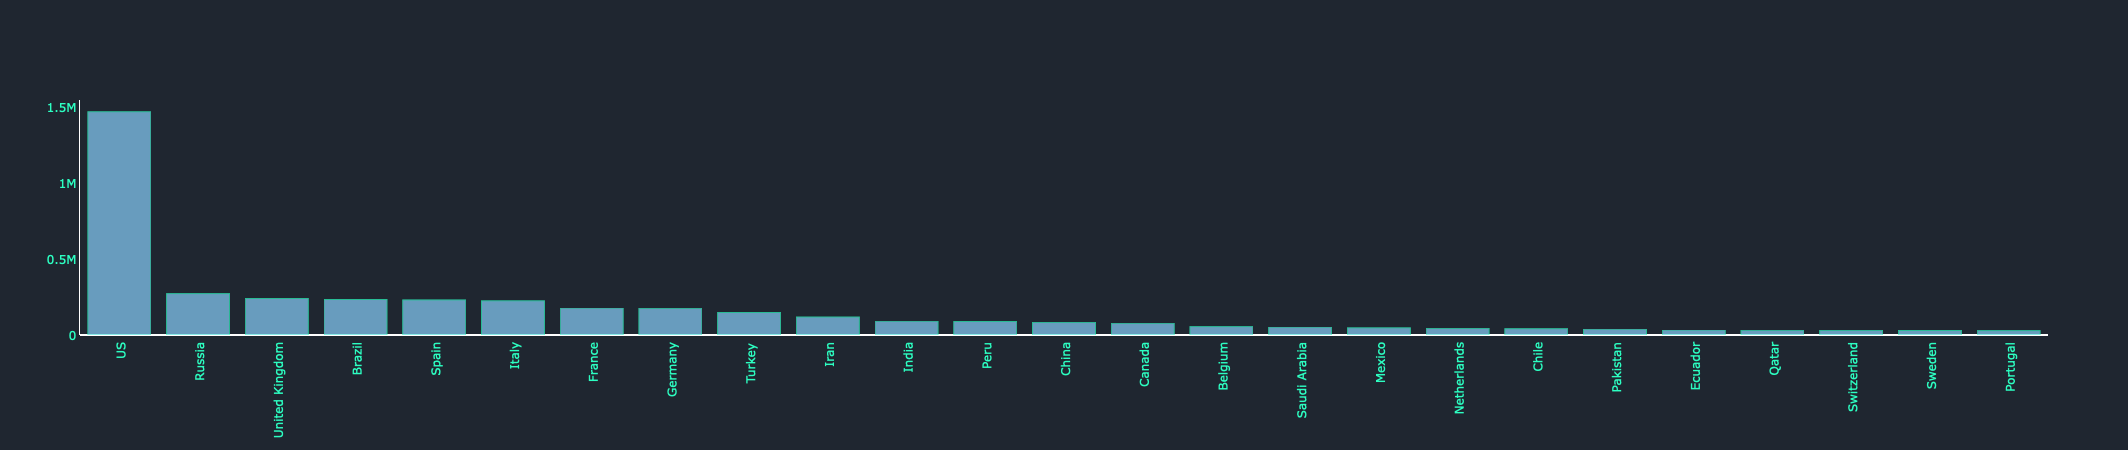

In [600]:
import plotly.graph_objects as go
#  aliceblue, antiquewhite, aqua, aquamarine, azure,
#             beige, bisque, black, blanchedalmond, blue,
#             blueviolet, brown, burlywood, cadetblue,
#             chartreuse, chocolate, coral, cornflowerblue,
#             cornsilk, crimson, cyan, darkblue, darkcyan,
#             darkgoldenrod, darkgray, darkgrey, darkgreen,
#             darkkhaki, darkmagenta, darkolivegreen, darkorange,
#             darkorchid, darkred, darksalmon, darkseagreen,
#             darkslateblue, darkslategray, darkslategrey,
#             darkturquoise, darkviolet, deeppink, deepskyblue,
#             dimgray, dimgrey, dodgerblue, firebrick,
#             floralwhite, forestgreen, fuchsia, gainsboro,
#             ghostwhite, gold, goldenrod, gray, grey, green,
#             greenyellow, honeydew, hotpink, indianred, indigo,
#             ivory, khaki, lavender, lavenderblush, lawngreen,
#             lemonchiffon, lightblue, lightcoral, lightcyan,
#             lightgoldenrodyellow, lightgray, lightgrey,
#             lightgreen, lightpink, lightsalmon, lightseagreen,
#             lightskyblue, lightslategray, lightslategrey,
#             lightsteelblue, lightyellow, lime, limegreen,
#             linen, magenta, maroon, mediumaquamarine,
#             mediumblue, mediumorchid, mediumpurple,
#             mediumseagreen, mediumslateblue, mediumspringgreen,
#             mediumturquoise, mediumvioletred, midnightblue,
#             mintcream, mistyrose, moccasin, navajowhite, navy,
#             oldlace, olive, olivedrab, orange, orangered,
#             orchid, palegoldenrod, palegreen, paleturquoise,
#             palevioletred, papayawhip, peachpuff, peru, pink,
#             plum, powderblue, purple, red, rosybrown,
#             royalblue, rebeccapurple, saddlebrown, salmon,
#             sandybrown, seagreen, seashell, sienna, silver,
#             skyblue, slateblue, slategray, slategrey, snow,
#             springgreen, steelblue, tan, teal, thistle, tomato,
#             turquoise, violet, wheat, white, whitesmoke,
#             yellow, yellowgreen
df = df.loc[df.index == df.index.max()].sort_values('confirmed', ascending=False).head(25)
color = '#1f2630'
gray_color = 'rgb(204, 204, 204)'
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['land'],
    y=df['confirmed'],
#     name='Name',
    marker=dict(color='lightskyblue',
                opacity=0.7,
                line=dict(
                    color='#2cfec1',
                    width=1
                 )
)))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-90,
                 plot_bgcolor=color,
                      paper_bgcolor=color,
                 yaxis=dict(
                     showline=True,
            showgrid=False,
#         title='USD (millions)',
#         titlefont_size=16,
#         tickfont_size=14,
        tickfont_color='#2cfec1',
                     color=color
    ),
                  xaxis=dict(
#         title='USD (millions)',
#         titlefont_size=16,
#         tickfont_size=14,
        tickfont_color='#2cfec1',color=color
    )
                  
                  ,)
fig.show()